In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../utils/")
# from res_processing_utils import get_ave_metric, running_mean
from res_processing_utils import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from plot_utils import save_csv, save_csv_only_y
from plot_utils import get_config_with_best_train_loss, get_config_with_best_test_acc
from plot_utils import plot_test_acc, plot_train_loss
from plot_utils import plot_best_config_multiple_epochs
from plot_utils import plot_best_config_fixed_epochs, plot_best_config_fixed_epochs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lstm_dec_24_conll2000/"
pattern = "opt_sgd_momentum_0.0_lr_0.5_l2_reg_0.0001_"
train_loss = get_ave_metric(pattern, top_directory, seed_list=[1,], metric="train_loss")
test_loss = get_ave_metric(pattern, top_directory, seed_list=[1,], metric="test_loss")
test_acc = get_ave_metric(pattern, top_directory, seed_list=[1,], metric="test_acc")
grad_norm = get_ave_metric(pattern, top_directory, seed_list=[1,], metric="grad_norm")

In [6]:
train_loss.shape, test_loss.shape, test_acc.shape, grad_norm.shape

((55800,), (100,), (100,), (55800,))

In [7]:
train_loss[-1], test_loss[-1], test_acc[-1], grad_norm[-1]

(0.3201169972658158,
 0.25886011440912343,
 0.9585066949088433,
 0.2700388891854503)

In [12]:
def get_config_with_best_train_loss(top_directory, pattern_list, seed_list=[1, 2, 3], win_width=1000, cut_off_epoch=100, total_epoch=100, epoch_len=391):
        best_train_loss = np.finfo(dtype=np.float64).max 
        best_config = ""
        best_loss_epoch_id = 0
        for pattern in pattern_list:
                ave_loss = None
                if 1:
#                 try:
                    for seed in seed_list:
                            #print(pattern, seed)
                            dir = pattern + "seed_" + str(seed)
                            if not os.path.exists(top_directory + "/" + dir + "/run.log"):
                                    print(top_directory + "/" + dir + "/run.log missing!" )
                                    continue
                            loss = get_train_loss(top_directory + "/" + dir + "/run.log")[(-epoch_len * total_epoch):]
                            if len(loss) == 0:
                                    print(top_directory + "/" + dir + "/run.log has 0 train loss record" )
                                    continue
                            if ave_loss is None:
                                     ave_loss = np.array(loss)
                            else:
                                     ave_loss += np.array(loss)
                    ave_loss /= len(seed_list)
                    assert cut_off_epoch <= total_epoch
                    iter_thresh = ave_loss.size * cut_off_epoch // total_epoch
                    ave_loss = ave_loss[:iter_thresh]
                    ave_loss_test = running_mean(ave_loss, N=win_width)
                    ave_loss = np.reshape(ave_loss, (-1, epoch_len))
#                     print(ave_loss, ave_loss_test)
                    ave_loss = np.mean(ave_loss, axis=1).reshape((ave_loss.shape[0], ))
#                     print(ave_loss)
                    #print(pattern, np.min(ave_loss))
                    if np.min(ave_loss) <  best_train_loss:
                            best_train_loss = np.min(ave_loss)
                            best_train_loss_full = ave_loss
                            best_config = pattern
                            best_loss_epoch_id = np.argmin(ave_loss)
#                 except:
#                         continue
        print("best train loss and config ", best_train_loss, best_loss_epoch_id, best_config)
        return (best_train_loss_full, best_loss_epoch_id, best_train_loss, best_config)

In [20]:
def plot_train_loss(label_list, train_loss_list):
    plt.figure()
    data_list = []
    for train_loss, label in zip(train_loss_list, label_list):
        data_list.append((label, np.arange(train_loss.size) + 1, train_loss))
#         plt.semilogy(np.minimum.accumulate(train_loss), label=label)
        plt.semilogy(train_loss, label=label)
    plt.legend()
#     plt.ylim([None, 1e-1])
    plt.xlabel("Iterations")
    plt.ylabel("Training loss")
#     plt.title("CIFAR10 (LeNet)")
    plt.grid()
    plt.show()
#     save_csv(data_list, file_name="./workspace/lenet_train_loss_all.csv")


In [21]:
def plot_best_config_fixed_epochs(cut_off_epoch=100, total_epoch=100, 
                                  win_width=1000, 
                                  top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lenet_hyper_sweep_2018_nov_17/", 
                                  epoch_len=391,
                                  seed_list=[1, 2, 3], 
                                  pattern_list_array=[ ["_bc-svrg",], 
                                                      ["_lp-svrg",],
                                                      ["_svrg",],
                                                      ["_bc-sgd",],
                                                      ["_lp-sgd",],
                                                      ["_sgd",]],
                                  plot_label_list=["halp", "svrg (16)", "svrg (32)", "bc-sgd (16)", "sgd (16)", "sgd (32)"]):
    all_directories = get_immediate_subdirectories(top_directory)
    all_directories = get_subdirectories_patterns_without_seed(all_directories)

    best_train_loss_list = []
    best_test_acc_list = []
    best_train_loss_config_list = []
    best_test_acc_config_list = []
    for pattern_list in pattern_list_array:
        print("\n")
        print(pattern_list)
        dir_list = filter_directory_names(all_directories, pattern_list)
        res = get_config_with_best_test_acc(top_directory, dir_list, cut_off_epoch=cut_off_epoch, total_epoch=total_epoch, seed_list=seed_list)
        best_test_acc_list.append(res[0])
        best_test_acc_config_list.append(res[1])
        res = get_config_with_best_train_loss(top_directory, dir_list, win_width=win_width, cut_off_epoch=cut_off_epoch, total_epoch=total_epoch, epoch_len=epoch_len, seed_list=seed_list)
        best_train_loss_list.append(res[0])
        best_train_loss_config_list.append(res[1])

    plot_test_acc(pattern_list_array, best_test_acc_list)
    plot_train_loss(pattern_list_array, best_train_loss_list)
    return best_test_acc_list, best_train_loss_list, plot_label_list


## overall report



['_bc-svrg', 'reg_0.0_']
best test acc and config  0.9943098002874651 99 opt_bc-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


best train loss and config  0.014213757702953926 99 opt_bc-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


['_lp-svrg', 'reg_0.0_']
best test acc and config  0.9776008964369468 86 opt_lp-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_
best train loss and config  0.05181891602000028 87 opt_lp-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


['_svrg', 'reg_0.0_']
best test acc and config  0.9943121643089492 84 opt_svrg_momentum_0.0_lr_5.0_l2_reg_0.0_
best train loss and config  0.014305787211689618 83 opt_svrg_momentum_0.0_lr_5.0_l2_reg_0.0_


['_lp-sgd', 'reg_0.0_']
best test acc and config  0.9834707617822831 94 opt_lp-sgd_momentum_0.0_lr_5.0_l2_reg_0.0_
best train loss and config  0.02880288964958601 94 opt_lp-sgd_momentum_0.0_lr_5.0_l2_reg_0.0_


['_sgd', 'reg_0.0_']
best test acc and config  0.983969570315455 99 opt_sgd_momentum_0.9_lr_0.5_l2_reg_0.0_
best train loss and config  0.0223673198524008 99 opt_sgd_momentum_0.9_lr_0.5_l2_reg_0.0_


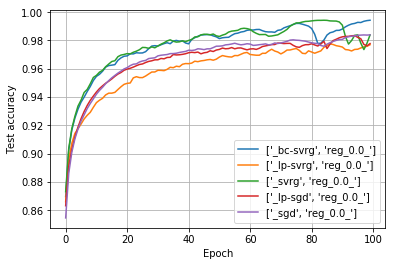

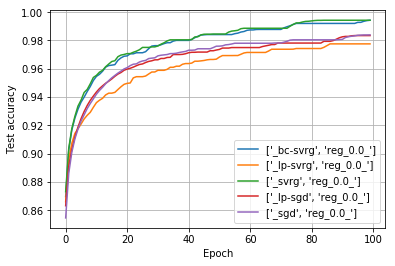

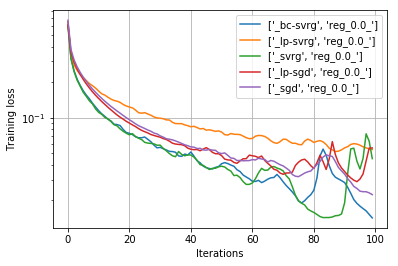

In [22]:
best_test_acc_list, best_train_loss_list, plot_label_list = \
plot_best_config_fixed_epochs(top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lstm_dec_24_conll2000/",
                              cut_off_epoch=100, 
                              total_epoch=100, 
                              win_width=100, 
                              epoch_len=558,
                              seed_list=[1, 2],
                              pattern_list_array=[ ["_bc-svrg", "reg_0.0_"],
                                                      ["_lp-svrg", "reg_0.0_"],
                                                      ["_svrg", "reg_0.0_"],
                                                      ["_lp-sgd", "reg_0.0_"],
                                                      ["_sgd", "reg_0.0_"]])



['_bc-svrg']
best test acc and config  0.9943098002874651 99 opt_bc-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


/home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


best train loss and config  0.014213757702953926 99 opt_bc-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


['_lp-svrg']
best test acc and config  0.9776008964369468 86 opt_lp-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_
best train loss and config  0.05181891602000028 87 opt_lp-svrg_momentum_0.9_lr_0.5_l2_reg_0.0_


['_svrg']
best test acc and config  0.9943121643089492 84 opt_svrg_momentum_0.0_lr_5.0_l2_reg_0.0_
best train loss and config  0.014305787211689618 83 opt_svrg_momentum_0.0_lr_5.0_l2_reg_0.0_


['_lp-sgd']
best test acc and config  0.9834707617822831 94 opt_lp-sgd_momentum_0.0_lr_5.0_l2_reg_0.0_
best train loss and config  0.02880288964958601 94 opt_lp-sgd_momentum_0.0_lr_5.0_l2_reg_0.0_


['_sgd']
best test acc and config  0.983969570315455 99 opt_sgd_momentum_0.9_lr_0.5_l2_reg_0.0_
best train loss and config  0.0223673198524008 99 opt_sgd_momentum_0.9_lr_0.5_l2_reg_0.0_


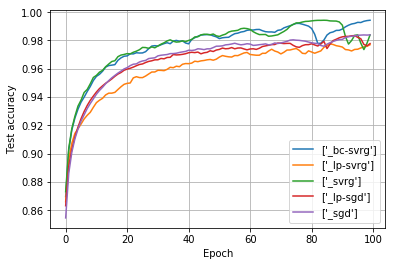

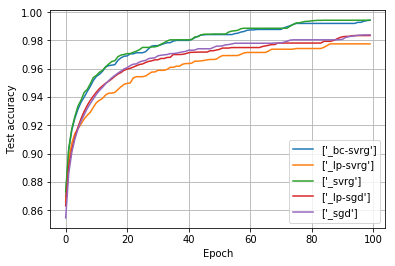

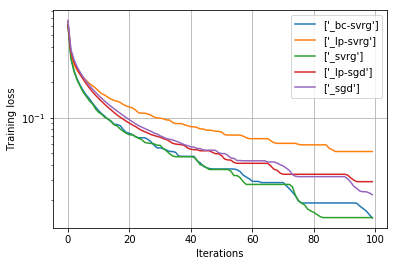

In [19]:
best_test_acc_list, best_train_loss_list, plot_label_list = \
plot_best_config_fixed_epochs(top_directory = "/dfs/scratch0/zjian/floating_halp/exp_res/lstm_dec_24_conll2000/",
                              cut_off_epoch=100, 
                              total_epoch=100, 
                              win_width=100, 
                              epoch_len=558,
                              seed_list=[1, 2,],
                              pattern_list_array=[ ["_bc-svrg"],
                                                      ["_lp-svrg"],
                                                      ["_svrg"],
                                                      ["_lp-sgd"],
                                                      ["_sgd"]])